In [3]:
import sys
# sys.path.append(r"Y:\Users\Yingyue\Gates_Lab_Suite-master")
sys.path.append(r"/Users/yzhu/yzhu_work/gates projects")
from Core_Definition import *
from Auto_Algorithm import *
from Visualization import *
import os
from SPAM import *
import numpy as np
import xlsxwriter as xlsx
from scipy import optimize
import random
import math
from math import floor
import uuid

In [4]:
import json, pickle
import qiskit
#transpiler reducinig qiskit circuit to QASM strings
from qiskit import transpile
# Use AerSimulator
from qiskit_aer import AerSimulator
from qiskit import IBMQ, QuantumCircuit, execute
# from qiskit.providers.ibmq.managed import IBMQJobManager
from qiskit.extensions import UnitaryGate
from qiskit.quantum_info import Pauli, Clifford, Statevector,Operator
from qiskit.visualization import array_to_latex
from scipy.stats import sem, unitary_group
from scipy.linalg import sqrtm,expm
import qiskit.quantum_info as qi
from qiskit.quantum_info import Pauli
import pylatexenc

/var/folders/6l/f5pw0tyx785dhvmqpb7282h00000gn/T/ipykernel_30376/1375469573.py:9: DeprecationWarning: The qiskit.extensions module is deprecated since Qiskit 0.46.0. It will be removed in the Qiskit 1.0 release.
  from qiskit.extensions import UnitaryGate


In [ ]:
## Additional functions

def int_to_pauli(i,n):
    p = np.base_repr(i,base=4)
    p = '0'*(n-len(p)) + p
    p = p.replace('0','I').replace('1', 'X').replace('2', 'Y').replace('3', 'Z')
    return p

def commute(p,q):
    c = 1
    n = len(p)
    for i in range(n):
        if p[i] != 'I' and q[i] != 'I':
            if p[i] != q[i]:
                c *= -1
    return c

In [ ]:
#define error model parameters

import math
from math import pi
from qiskit.quantum_info import Statevector
from qiskit_aer.noise import (NoiseModel, QuantumError, ReadoutError,
    pauli_error, depolarizing_error, thermal_relaxation_error)

#basic t2 error model
# T1 and T2 values for qubit
T1 = 1000000000000
T2 = 50000000


In [ ]:
# Set_Mapping([1,3,4,5,2])
nqubit=2
# ancillae=2
S=Quantum_Circuit(2*nqubit,"qc")
# S_explicit=Quantum_Circuit(2*nqubit,"qc_e")
total_depth=5
depth=[2**x for x in range(1,total_depth+1)] #depth for Concatenation
C=20#number of samples per depth

all_circuits=[]#a list of lists. circuits for all depths. each element is a list of circuit of a certain depth d.
all_circuits_explicit=[]
circuits=[] #a list of circuits with a certain depth d
circuits_explicit=[]
eab_data=[] #a list of dictionaries. Each dictionary is the results and relevant info of one circuit
results={}

clifford_layer="CNOT"
#for qiskit 
backend = AerSimulator()
# t_echo=0

for d in depth:
    print ("\nDepth = %d"%d)
    print ("Number of samples = %d"%C)
    time_delay= (300+80)*d*1000 #in ns
    noise_model = NoiseModel()
    errors_delay = [thermal_relaxation_error(T1, T2, time_delay)]*nqubit
    for j in range (nqubit):
        noise_model.add_quantum_error(errors_delay[j], "delay",[nqubit+j])

    for i in range (C):
# #gates circuitt
#         S.depth=0
#         S.gates=[]
# #gates explicit cnot circuit    
#         S_explicit.depth=0
#         S_explicit.gates=[]

#qiskit_circ=QuantumCircuit(2*nqubit,2*nqubit)
        qiskit_c_state = QuantumCircuit(2*nqubit,2*nqubit)
        qiskit_c_gates = QuantumCircuit(nqubit)

        # #gates circuit state prep
        # state_init_bell_pairs(S,nqubit)
        # #gates explicit CNOT circuit state prep
        # state_init_bell_pairs_explicitCNOT(S_explicit,nqubit)
        #qiskit circuit state prep
        for j in range(nqubit):
            prepare_bell_state_1q(qiskit_c_state,j,j+nqubit)
        qiskit_c_state.barrier()

        
        for j in range(d):
            #gates circuit add pauli layer
            layer=add_pauli_twirl(S,nqubit)
            # #gates explicit cnot circuit add pauli layer
            # layer=add_pauli_twirl(S_explicit,nqubit)
            
            #qiskit circuit add pauli layer
            for q in range(nqubit):
                pauli_gate_1q(qiskit_c_gates,q,pauli=layer[q])


            # #gates circuit add clifford layer
            # add_clifford_layer(S,nqubit,clifford_layer)
            # #gates explicit cnot circuit add clifford layer
            # add_clifford_layer(S_explicit,nqubit,clifford_layer)
          
            #qiskit circuit add clifford layer
            if clifford_layer == 'Id':
                pass
            elif clifford_layer == 'CNOT':
                ngates = int(nqubit/2)
                for q in range(ngates):
                    qiskit_c_gates.cx(2*q,2*q+1)
            elif clifford_layer == 'XX':
                ngates = int(nqubit/2)
                for q in range(ngates):
                    add_XX_clifford(qiskit_c_gates,q)
            qiskit_c_gates.barrier()
            
        #gates circuit add Pauli twirl
        layer=add_pauli_twirl(S,nqubit)
        # #gates explicit cnot circuit add Pauli twirl
        # layer=add_pauli_twirl(S_explicit,nqubit)
        #qiskit circuit add Pauli twirl
        for j in range(nqubit):
            pauli_gate_1q(qiskit_c_gates,j,pauli=layer[j])
            #save the stablizer representation
        cliffordOp = Clifford(qiskit_c_gates)

        
        #for qiskit: append gates to state
        qiskit_circ = qiskit_c_state.compose(qiskit_c_gates,range(nqubit))

        # add dephasing noise to ancilla qubits
        for j in range (nqubit,2*nqubit):
            qiskit_circ.delay(time_delay,unit="ns",qarg=j)
        
        # #gates circuti bell measurement
        # bell_measurement(S,nqubit)
        # #gates explicit cnot circuti bell measurement
        # bell_measurement_explicitCNOT(S_explicit,nqubit)
        
        #qiskit circuti bell measurement
        for j in range(nqubit):
            bell_measurement_1q(qiskit_circ,j,j+nqubit)
        qiskit_circ.barrier(range(2*nqubit))
        qiskit_circ.measure(range(2*nqubit),range(2*nqubit))
        
        # qiskit_circ.draw('mpl')

#         #for qiskit 
        qc_compiled = transpile(qiskit_circ, backend)
        job_sim = backend.run(qc_compiled, shots=2000,noise_model=noise_model)
        result_sim = job_sim.result()
        counts_qiskit = result_sim.get_counts(qc_compiled)


#         # circuits.append(S.GatesLab_Sequence())
#         # circuits_explicit.append(S_explicit.GatesLab_Sequence())

# #stuff not needed
# #         print (S.GatesLab_Sequence())
# #         print (S_explicit.GatesLab_Sequence())
# #         statef=S.Simulate()
# #         statef=S_explicit.Simulate()
# #         statef.population=[round (x) for x in statef.population]
# #         statef_explicit.population=[round (x) for x in statef_explicit.population]
# #         print (statef.population)
# #         print (statef_explicit.population)  
                   
#         #package and format results
        results["n"]=nqubit
        results["L"]=d
        results["clifford"] = cliffordOp.to_dict()
        results["clifford_layer"] = clifford_layer
# #         statef=S.Simulate()
#         statef=S_explicit.Simulate()
#         counts=[round(2000*x) for x in statef.population]
        
#         counts_ibm_mapping, counts_ibm_mapping_dic=map_statepop_2_ibm_mapping(counts,nqubit)
        results["counts"]=counts_qiskit
        eab_data.append(results)
# #         if 0==0:
# #             print (results)
# #             print(counts_qiskit)
# #             print (cliffordOp)
        results={}
        
#     all_circuits.append(circuits)
#     all_circuits_explicit.append(circuits_explicit)
#     for line in circuits_explicit:
#         print (line)
#     circuits=[]
#     circuits_explicit=[]

# filename = str(uuid.uuid4())
# filename+="XX13452noS_explicitCNOT_FT_0516"
# with open("/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master/PauliNoiseEstimation/data/"+filename, "wb") as fp:
#     pickle.dump(eab_data, fp)



Depth = 2
Number of samples = 20

Depth = 4
Number of samples = 20

Depth = 8
Number of samples = 20

Depth = 16
Number of samples = 20

Depth = 32
Number of samples = 20


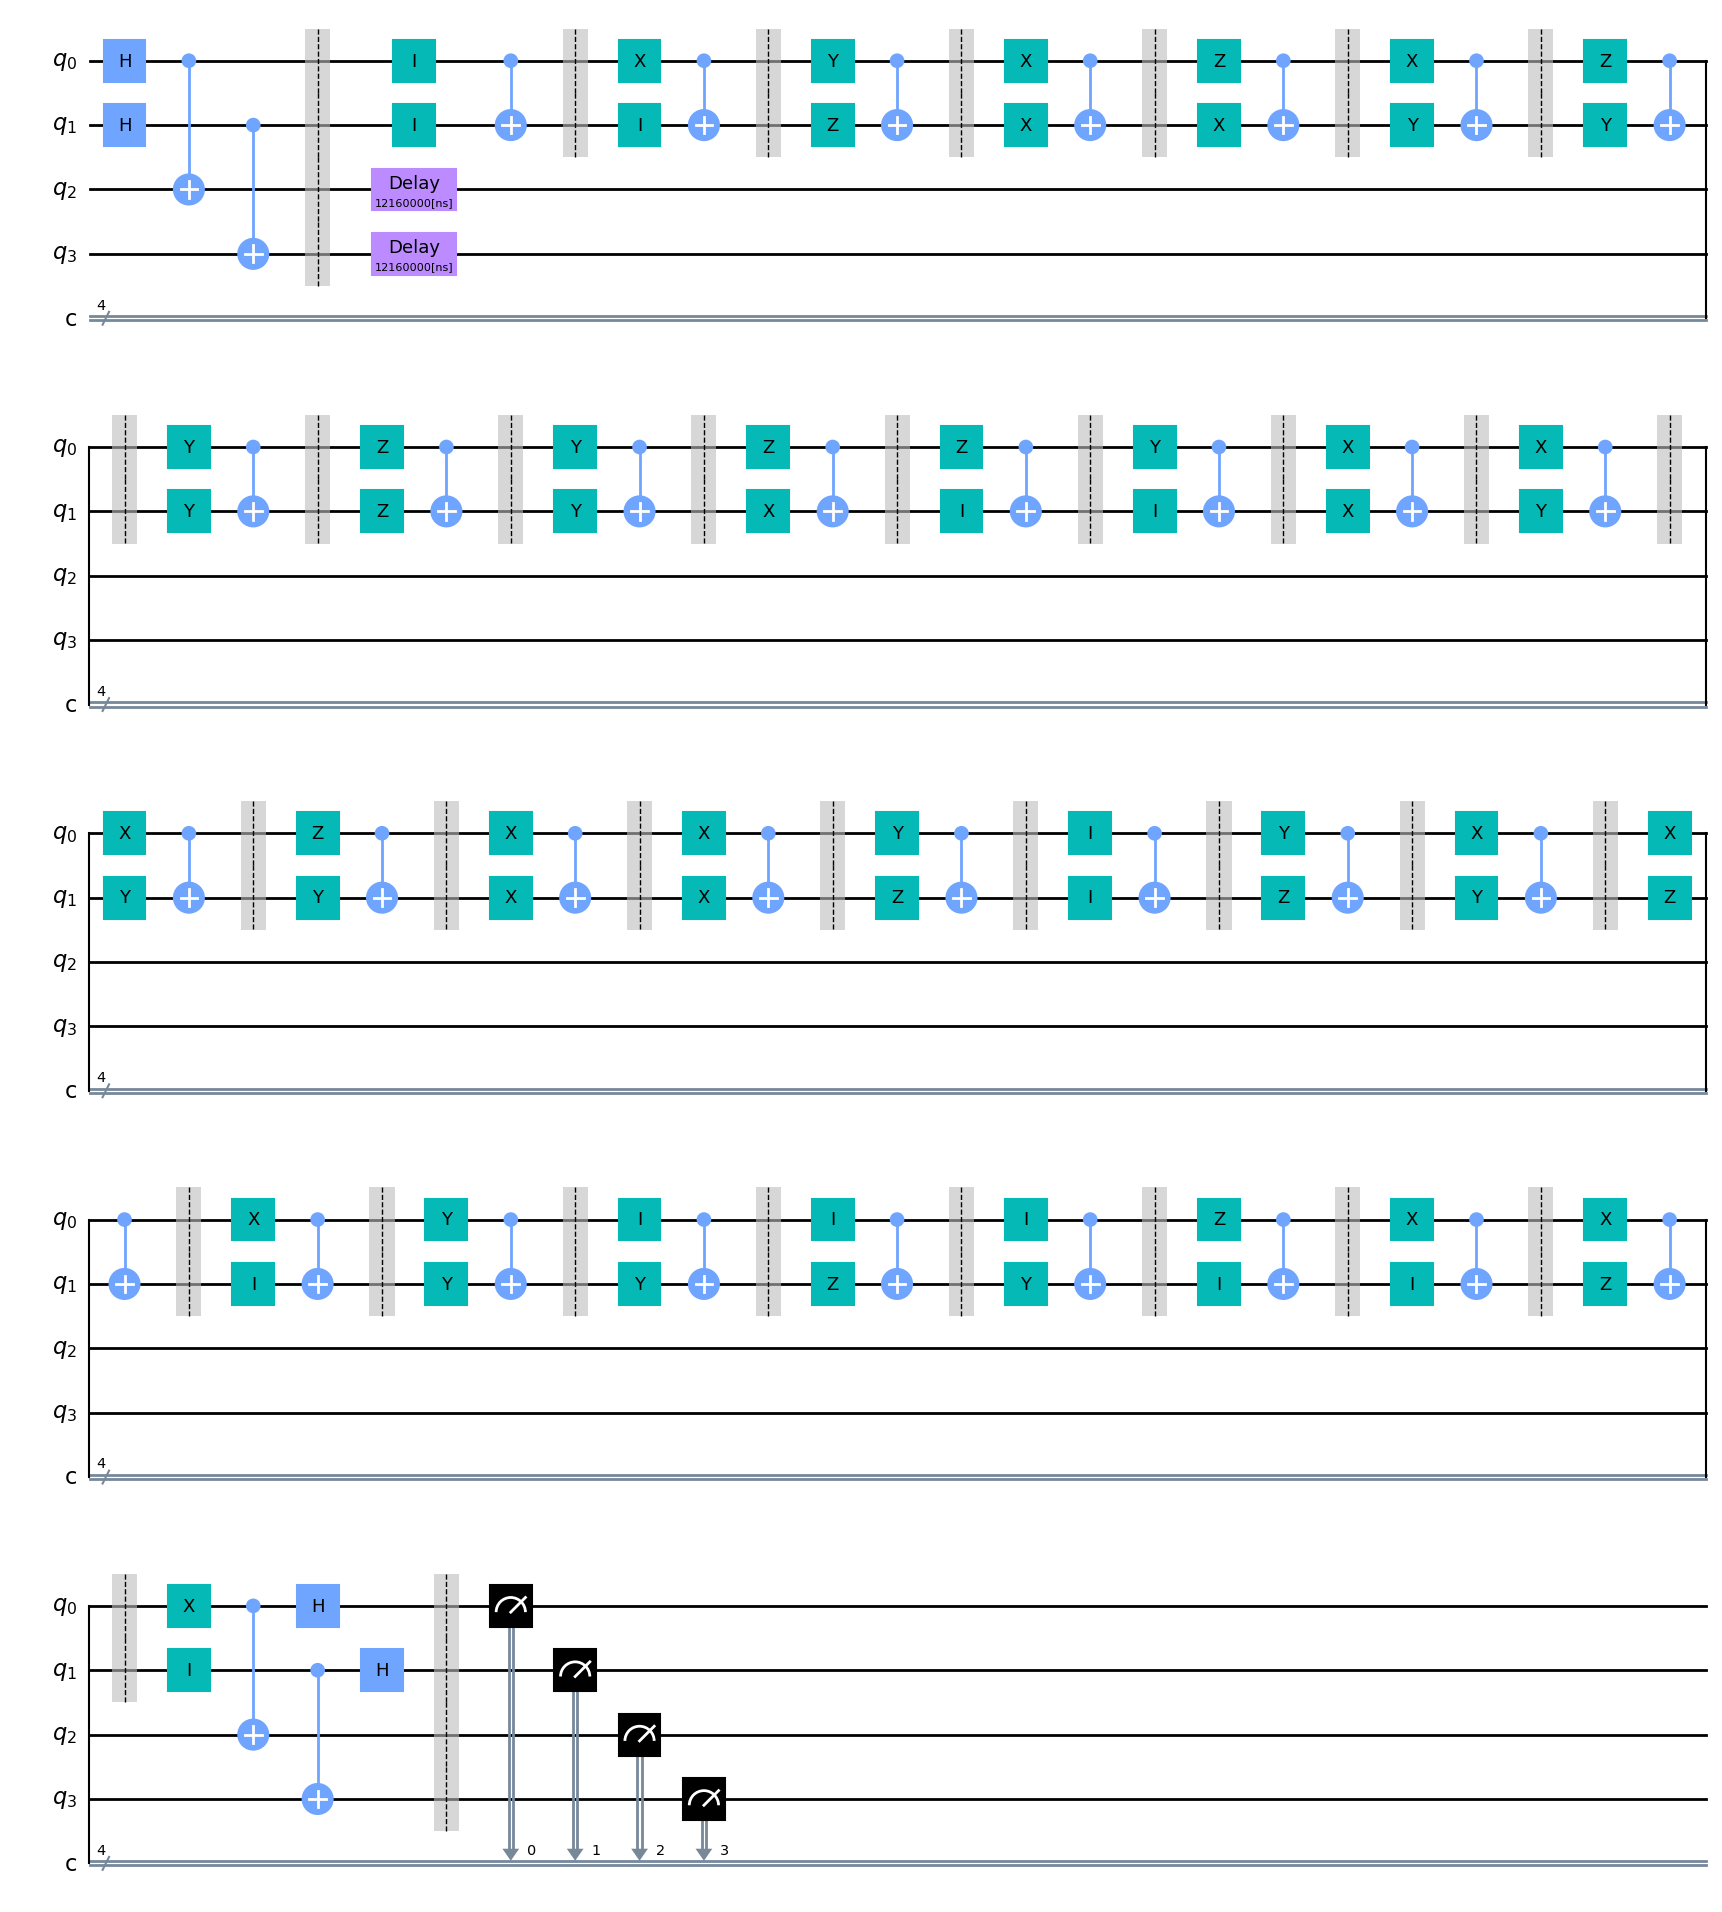

In [ ]:
qiskit_circ.draw('mpl')

In [ ]:
sys.path.append(r"/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master/PauliNoiseEstimation")
import EAB_process_modified 
import itertools
'''Specify a set of Pauli you want to estimate'''
pauli_request_list = [''.join(s) for s in itertools.product(['I','X','Y','Z'], repeat = nqubit)] #full

#process_EAB(Lrange, cb_data, pauli_request_list)
eab_result=EAB_process_modified.process_EAB(depth, eab_data, pauli_request_list)

print (eab_result)

{'fidelity_list': {'II': {2: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 4: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 8: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 16: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 32: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]}, 'IX': {2: [0.979, 0.984, 0.981, 0.986, 0.988, 0.974, 0.985, 0.983, 0.983, 0.984, 0.986, 0.989, 0.984, 0.989, 0.987, 0.982, 0.987, 0.987, 0.985, 0.978], 4: [0.971, 0.969, 0.971, 0.973, 0.97, 0.964, 0.966, 0.97, 0.97, 0.965, 0.979, 0.976, 0.971, 0.971, 0.972, 0.981, 0.968, 0.971, 0.962, 0.969], 8: [0.948, 0.938, 0.941, 0.944, 0.929, 0.942, 0.949, 0.931, 0.951, 0.945, 0.942, 0.948, 0.95, 0.945, 0.933, 0.94, 0.94, 0.949, 0.941, 0.927], 16: [0.875

In [ ]:
raw_fidelity_list = eab_result["fidelity_list"]


# sys.exit(0)

fidelity_list = {}
stdev_list = {}

for pauli_label in pauli_request_list:
    if(pauli_label == 'I'*nqubit):
        fidelity_list[pauli_label] = 1.0
        stdev_list[pauli_label] = 0.0
    else:
        alpha, alpha_err = EAB_process_modified.fit_EAB(depth, raw_fidelity_list[pauli_label])
        fidelity_list[pauli_label] = alpha
        stdev_list[pauli_label] = alpha_err

# print(fidelity_list)

# print(stdev_list)
print("Parameters: n = %d, C = %d, " % (nqubit,C), "L = ", str(depth))
use_density_matrix=False
use_readout_error =False
shots=2000
if use_density_matrix:
    print("Density matrix based simulation")
else:
    print("Measurement based simulation, shots = %d" % shots)

if use_readout_error is True:
    print("Measurement bitflip rate = %f" % eps_readout)
else:
    print("No readout error")

# Average fidelity
print("Total error = ", 1-np.mean(list(fidelity_list.values())))

print("Label / Pauli infidelity / Standard deviation")
for pauli_label in pauli_request_list:
    print(pauli_label[::-1], 1-fidelity_list[pauli_label], stdev_list[pauli_label])
# print('Effective noise rate = ' + str(1-np.average(list(fidelity_list.values()))))


Parameters: n = 2, C = 20,  L =  [2, 4, 8, 16, 32]
Measurement based simulation, shots = 2000
No readout error
Total error =  0.007418195491406099
Label / Pauli infidelity / Standard deviation
II 0.0 0.0
XI 0.007491762743785602 0.0001032952576392157
YI 0.007490367865921499 0.00010331101124928197
ZI 0.0 inf
IX 0.007447062443038499 0.00010548119056745074
XX 0.014734726439856183 0.00015994038086120845
YX 0.01473452687222332 0.00015973390144014563
ZX 0.007448494044998033 0.00010578029604421155
IY 0.00744583457752368 0.00010545752819969017
XY 0.014732678521700682 0.00016011725543461209
YY 0.014732474181365918 0.00015991188924145583
ZY 0.007447273675262878 0.00010575765214989782
IZ 0.0 inf
XZ 0.007493664151474677 0.00010315386639335186
YZ 0.0074922623453475 0.00010317060854410269
ZZ 0.0 inf


In [ ]:
np.save("IdwithT2error_sim_EAB_T2_50ms",[1-fidelity_list[pauli_label] for pauli_label in pauli_request_list])

In [ ]:
error_list = fidelity_to_error(fidelity_list,nqubit)
print("Label / Pauli error rates")
for pauli_label in pauli_request_list:
    print(pauli_label[::-1], error_list[pauli_label])

Label / Pauli error rates
II 0.998889011266246
XI -6.938893903907228e-18
YI 0.0
ZI 0.0005420867571843541
IX -1.284966970396817e-07
XX 6.938893903907228e-18
YX 0.0
ZX 9.684162455281253e-08
IY 3.060598716131402e-08
XY 6.938893903907228e-18
YY 0.0
ZY 1.0490852075939472e-09
IZ 0.0005611214179923954
XZ -6.938893903907228e-18
YZ 0.0
ZZ 7.780558577141772e-06


In [ ]:
# True value for this specific noise model
# eps=0
# def f_true(P):
#     ans = 0.0
#     for Pi in P:
#         if Pi == 'Z' or Pi == 'Y':
#             ans += 2*eps
#     return ans
# def p_true(P):
#     if P == "XI" or P == "IX":
#         return eps
#     else:
#         return 0.0

# print("Label / True infidelity/ True Pauli error")
# for P in pauli_request_list:
#     print(P[::-1]," ",f_true(P)," ",p_true(P))

Label / True infidelity/ True Pauli error
II   0.0   0.0
XI   0.0   0
YI   0.0   0.0
ZI   0.0   0.0
IX   0.0   0
XX   0.0   0.0
YX   0.0   0.0
ZX   0.0   0.0
IY   0.0   0.0
XY   0.0   0.0
YY   0.0   0.0
ZY   0.0   0.0
IZ   0.0   0.0
XZ   0.0   0.0
YZ   0.0   0.0
ZZ   0.0   0.0


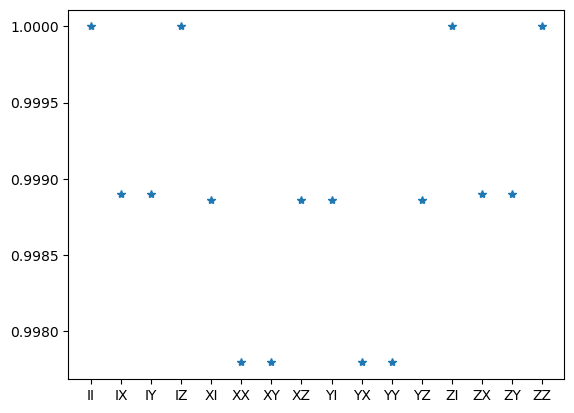

In [ ]:
plt.plot([pauli_label for pauli_label in pauli_request_list],[fidelity_list[pauli_label] for pauli_label in pauli_request_list],"*")